# 🚀 Introduction

In this notebook, I'll be working on a multiclass classification problem to classify 10 different species of monkeys 🐒. The dataset includes training and testing images for various monkey species.

![Image](https://1.bp.blogspot.com/-J0a4ohdYhro/XgRQr9j-fiI/AAAAAAABoqg/9r0EKQ9FnZocWGWaneMntucotcLAHsGUgCLcBGAsYHQ/s1600/9.jpg)

# 📊 Data Exploration

Let's deev into our project!

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get Images Paths
train_data = '/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Training Data/'
test_data  = '/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Prediction Data/'

# Get Class Names
class_names = sorted(os.listdir(train_data))
print(f"Class Names : {class_names}")

Class Names : ['Bald Uakari', 'Emperor Tamarin', 'Golden Monkey', 'Gray Langur', 'Hamadryas Baboon', 'Mandril', 'Proboscis Monkey', 'Red Howler', 'Vervet Monkey', 'White Faced Saki']


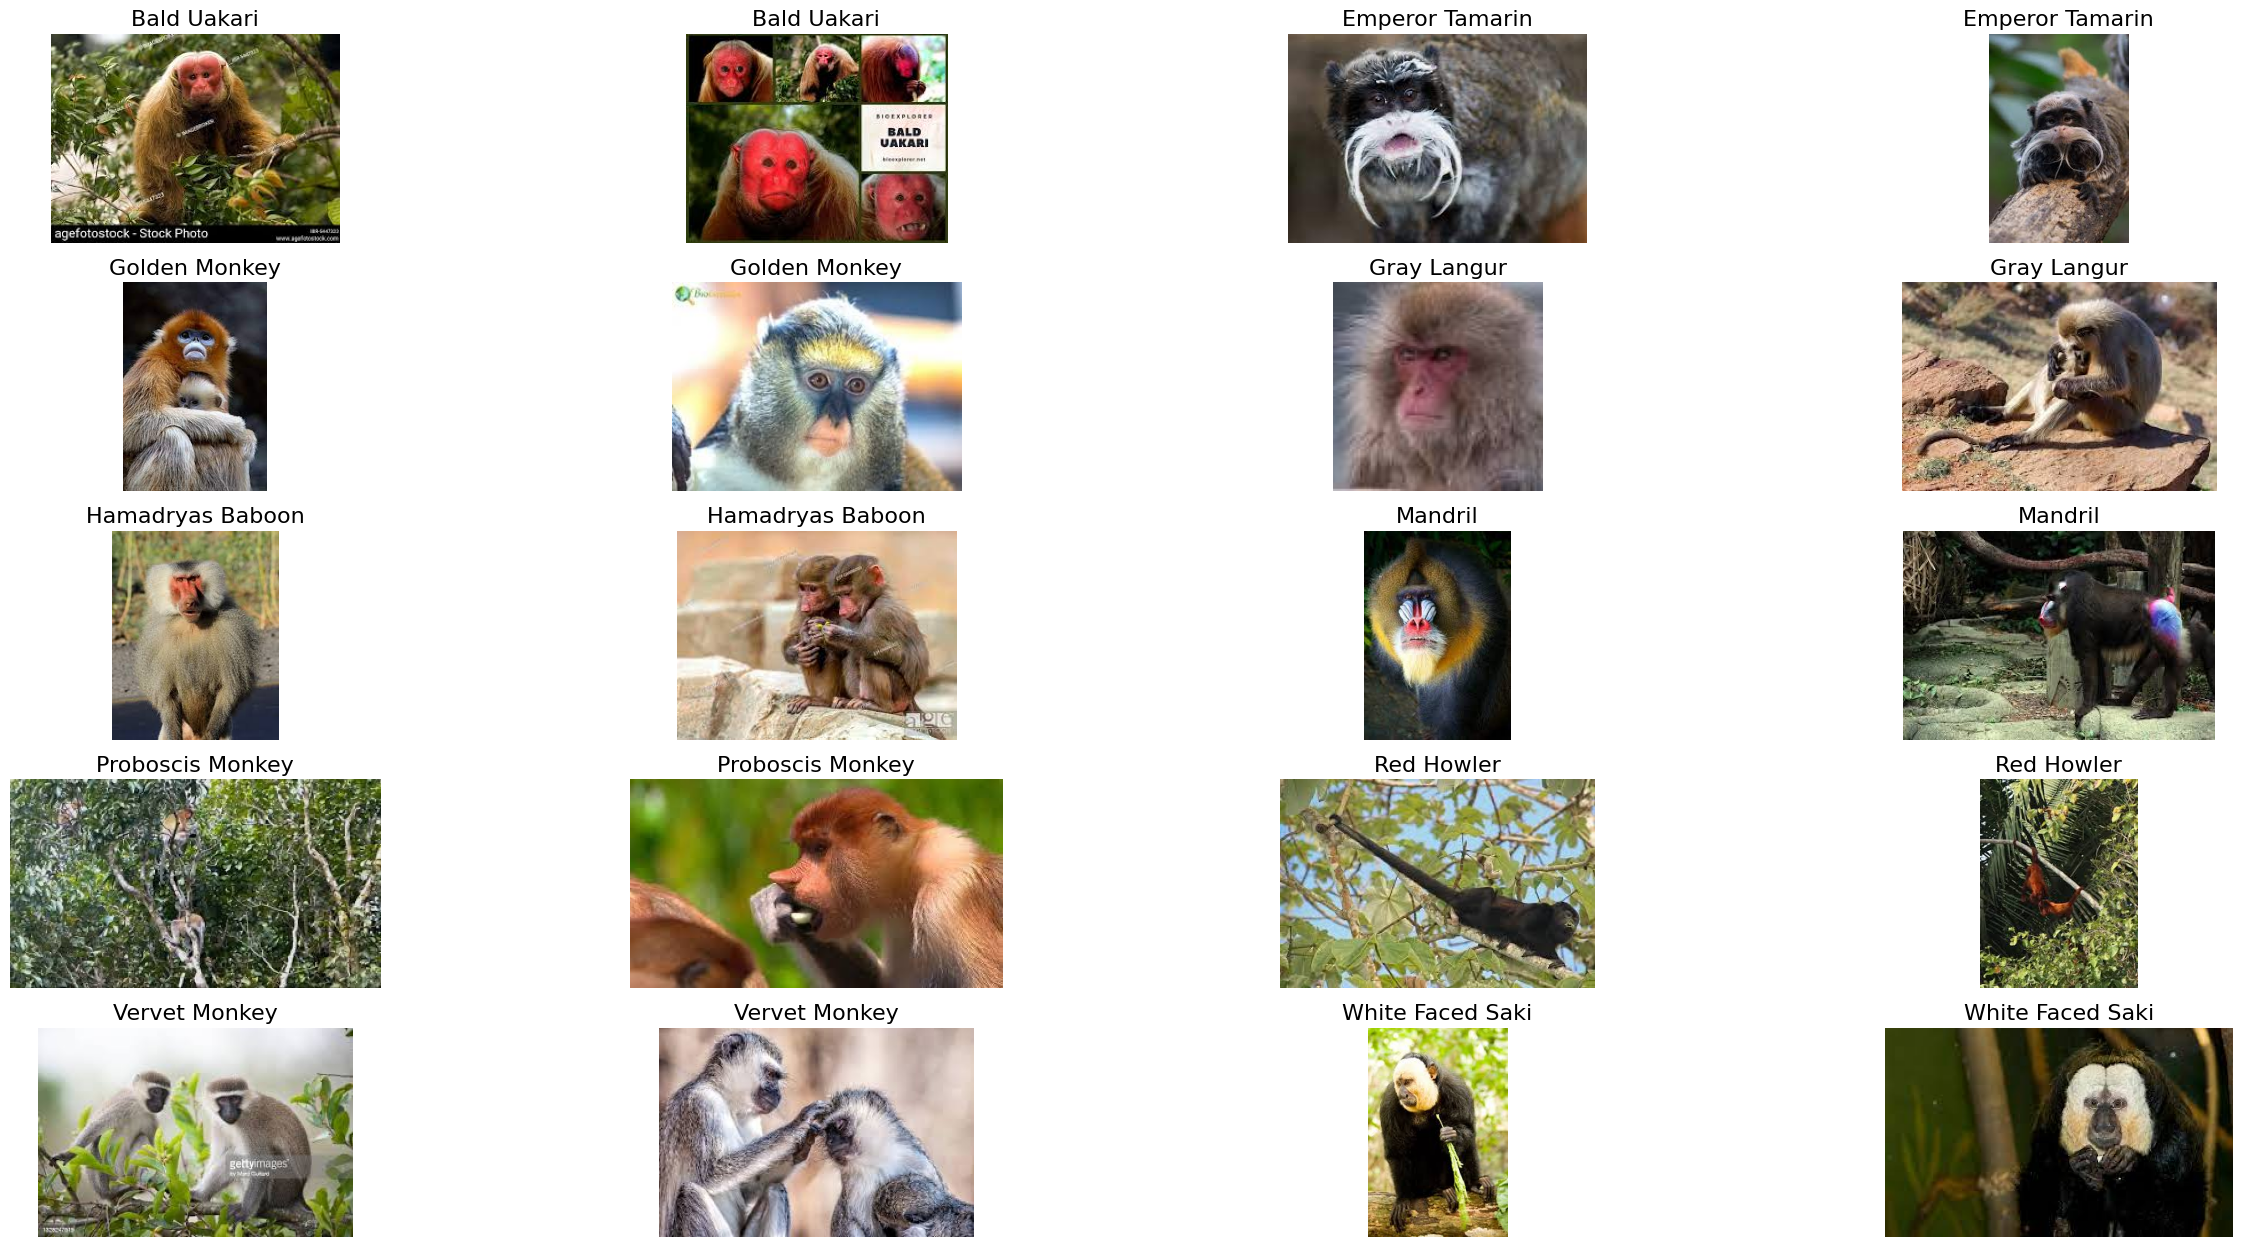

In [3]:
# Function to display 2 random images from each class in a 5x4 grid
def display_random_images(data_path, class_names, num_images_per_class=2):
    plt.figure(figsize=(25, 25))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        image_files = random.sample(os.listdir(class_path), num_images_per_class)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.subplot(len(class_names), 4, i * num_images_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name, fontsize=16)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 2 random images from each class in a 5x4 grid with even larger images
display_random_images(train_data, class_names)

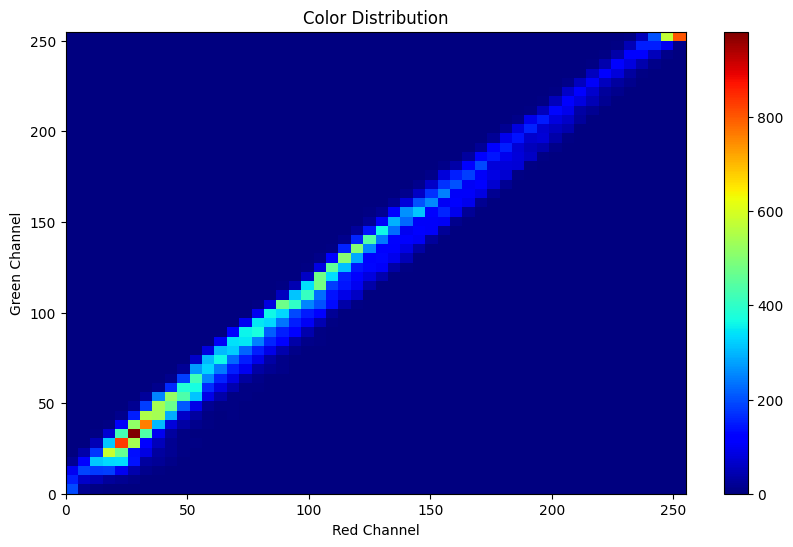

In [4]:
def plot_color_distribution(image):
    colors = image.reshape(-1, 3)
    plt.figure(figsize=(10, 6))
    plt.hist2d(colors[:, 0], colors[:, 1], bins=(50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('Color Distribution')
    plt.xlabel('Red Channel')
    plt.ylabel('Green Channel')
    plt.show()

# Load a random image for color distribution analysis
sample_class = random.choice(class_names)
sample_image = random.choice(os.listdir(os.path.join(train_data, sample_class)))
sample_image_path = os.path.join(train_data, sample_class, sample_image)
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Plot color distribution
plot_color_distribution(sample_image)

# 🛠️ Data Preprocessing
I'll split the training data into training and validation sets, create data generators, and augment the training images to improve model performance.

In [5]:
# Define your path for the training data
train_data_path = '/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Training Data'

# Get the list of class folders
class_folders = os.listdir(train_data_path)

# Define paths for training and validation data
train_split_path = '/kaggle/working/training_data'
val_split_path = '/kaggle/working/validation_data'

# Create directories if they don't exist
os.makedirs(train_split_path, exist_ok=True)
os.makedirs(val_split_path, exist_ok=True)

# Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(train_data_path, class_folder)
    images = os.listdir(class_path)

    # Split images into training and validation sets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create directories for each class in the training and validation sets
    train_class_path = os.path.join(train_split_path, class_folder)
    val_class_path = os.path.join(val_split_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)

    # Copy training images
    for image in train_images:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(train_class_path, image)
        copyfile(src_path, dest_path)

    # Copy validation images
    for image in val_images:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(val_class_path, image)
        copyfile(src_path, dest_path)

print(f"Training data saved to: {train_split_path}")
print(f"Validation data saved to: {val_split_path}")

Training data saved to: /kaggle/working/training_data
Validation data saved to: /kaggle/working/validation_data


In [6]:
# Function to create a data generator for training
def create_train_generator(data_path, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    generator = datagen.flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return generator

# Create data generators for training and validation
train_generator = create_train_generator(train_split_path, batch_size=16)
val_generator = create_train_generator(val_split_path, batch_size=16)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


# 🧠 Model Definition and Training
Now, let's define the CNN model and train it on the prepared dataset.

In [7]:
# Define the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(len(class_folders), activation='softmax'))  # Output layer with softmax activation for multiclass classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [8]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using the generator with early stopping and save the history
history = model.fit(train_generator, epochs=100, steps_per_epoch=train_generator.samples // 16, 
                    validation_data=val_generator, validation_steps=val_generator.samples // 16,
                    callbacks=[early_stopping])

Epoch 1/100
500/500 [==============================] - 115s 219ms/step - loss: 2.0142 - accuracy: 0.2474 - val_loss: 1.8063 - val_accuracy: 0.3405
Epoch 2/100
500/500 [==============================] - 108s 216ms/step - loss: 1.7579 - accuracy: 0.3627 - val_loss: 1.6465 - val_accuracy: 0.4100
Epoch 3/100
500/500 [==============================] - 110s 220ms/step - loss: 1.5624 - accuracy: 0.4470 - val_loss: 1.4228 - val_accuracy: 0.5055
Epoch 4/100
500/500 [==============================] - 110s 220ms/step - loss: 1.4378 - accuracy: 0.5074 - val_loss: 1.3604 - val_accuracy: 0.5355
Epoch 5/100
500/500 [==============================] - 109s 218ms/step - loss: 1.3241 - accuracy: 0.5487 - val_loss: 1.2726 - val_accuracy: 0.5705
Epoch 6/100
500/500 [==============================] - 109s 218ms/step - loss: 1.2417 - accuracy: 0.5854 - val_loss: 1.1431 - val_accuracy: 0.6055
Epoch 7/100
500/500 [==============================] - 109s 218ms/step - loss: 1.1607 - accuracy: 0.6037 - val_loss: 1

# 🚀 Model Evaluation
Evaluate the trained model on the test set, display some predictions, and visualize the confusion matrix.

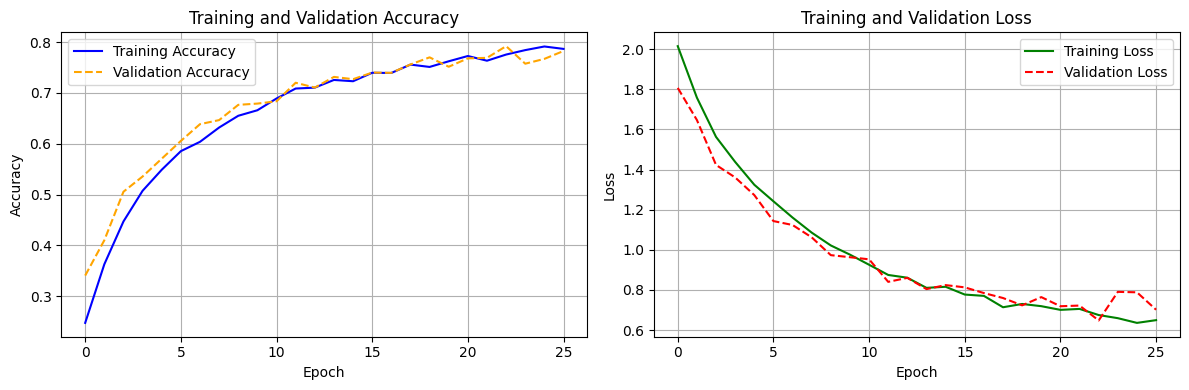

In [9]:
# Plot training history with subplots
plt.figure(figsize=(12, 4))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Path to the test data
test_data_path = '/kaggle/input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Prediction Data'

# Function to create a data generator for testing
def create_test_generator(data_path, batch_size=16):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # Set class_mode to None for prediction
        shuffle=False  # Ensure images are in the same order as predictions
    )

    return test_generator

# Create the test generator
test_generator = create_test_generator(test_data_path, batch_size=16)

# Predict the classes for the test set
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get the actual class labels
actual_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate the model on the test set
evaluation = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

# Check class indices
print("\nClass Indices:", test_generator.class_indices, "\n")

# Check actual vs. predicted labels for the first few samples
for i in range(min(5, len(actual_labels))):
    print(f"Actual: {class_labels[actual_labels[i]]}, Predicted: {class_labels[np.argmax(predictions[i])]}")

Found 1306 images belonging to 10 classes.
82/82 [==============================] - 5s 62ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Accuracy: 0.00%

Class Indices: {'Bald Uakari': 0, 'Emperor Tamarin': 1, 'Golden Monkey': 2, 'Gray Langur': 3, 'Hamadryas Baboon': 4, 'Mandril': 5, 'Proboscis Monkey': 6, 'Red Howler': 7, 'Vervet Monkey': 8, 'White Faced Saki': 9} 

Actual: Bald Uakari, Predicted: Bald Uakari
Actual: Bald Uakari, Predicted: Bald Uakari
Actual: Bald Uakari, Predicted: Bald Uakari
Actual: Bald Uakari, Predicted: Bald Uakari
Actual: Bald Uakari, Predicted: Bald Uakari


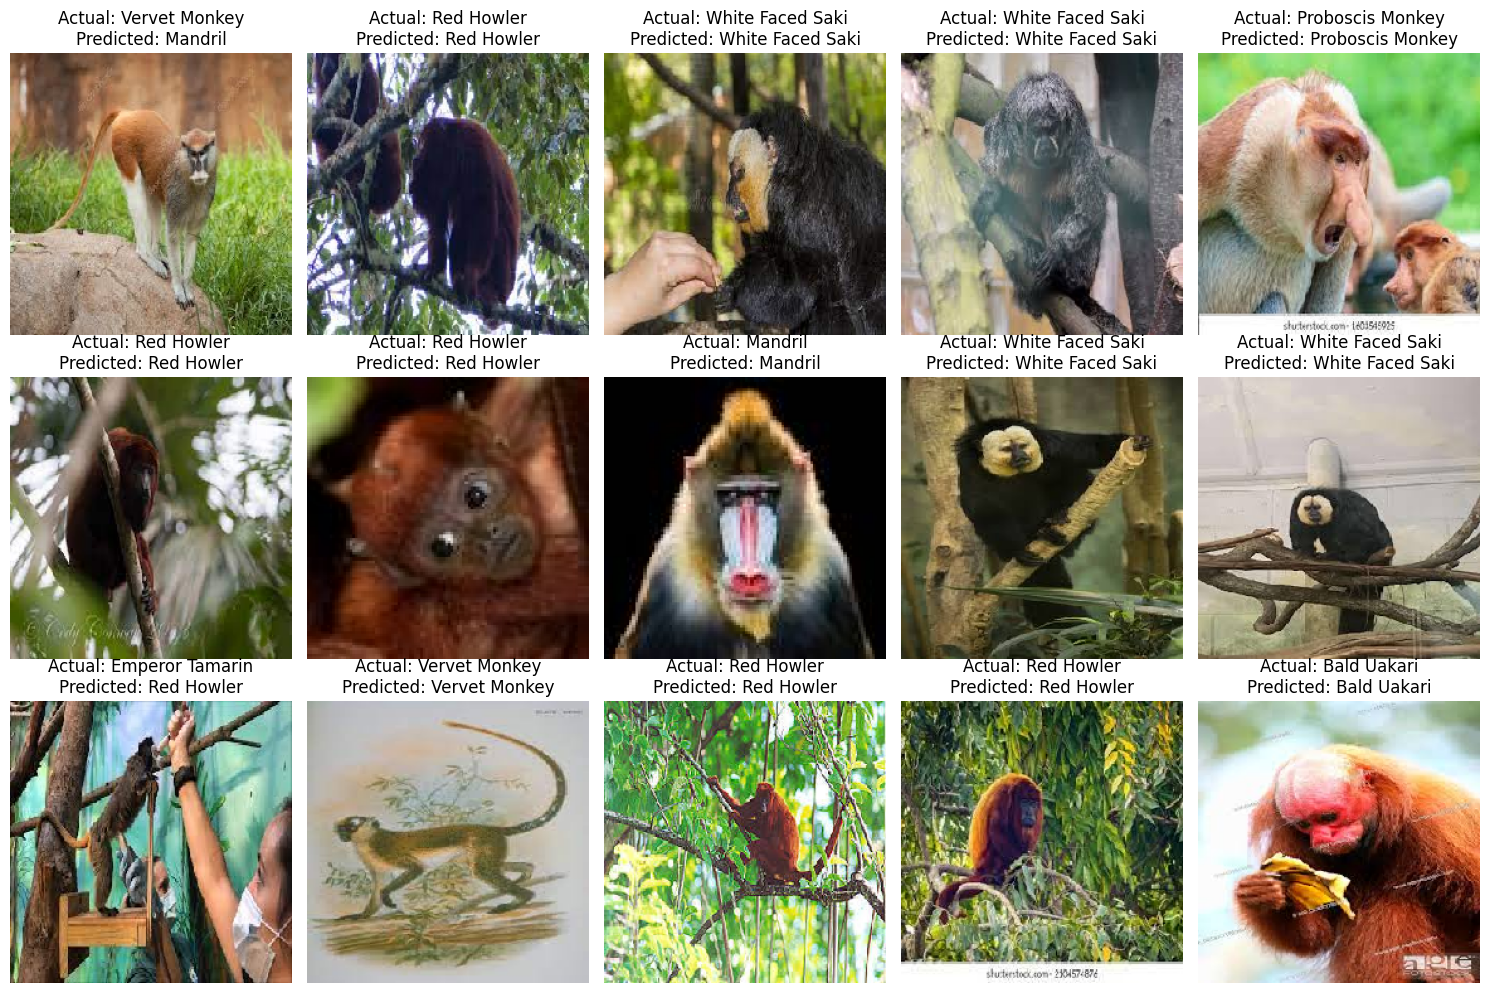

In [11]:
# Choose 15 random image indices
random_indices = np.random.choice(len(test_generator.filenames), size=15, replace=False)

# Display the 15 randomly selected images with actual and predicted class names
plt.figure(figsize=(15, 10))
for i, random_index in enumerate(random_indices, 1):
    # Get the actual and predicted labels for the random image
    actual_class = class_labels[actual_labels[random_index]]
    predicted_class = class_labels[np.argmax(predictions[random_index])]

    # Load and display the random image
    random_image_path = os.path.join(test_data_path, test_generator.filenames[random_index])
    random_image = load_img(random_image_path, target_size=(224, 224))

    plt.subplot(3, 5, i)
    plt.imshow(random_image)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

82/82 [==============================] - 5s 64ms/step


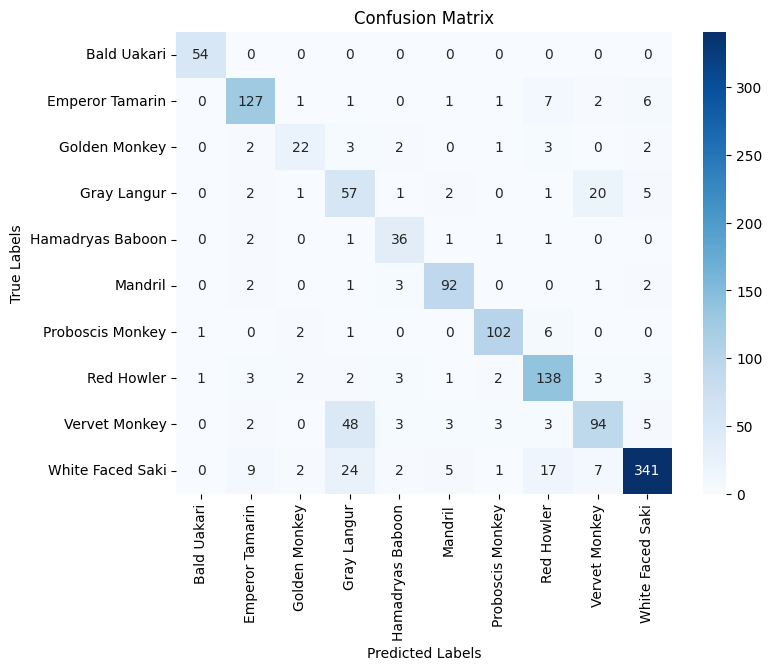

In [12]:
# Evaluate the model on the test set
test_generator.reset()  # Reset generator to ensure correct order
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get the actual class labels
actual_labels = test_generator.classes

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Classification Report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels, target_names=class_labels))


Classification Report:
                  precision    recall  f1-score   support

     Bald Uakari       0.96      1.00      0.98        54
 Emperor Tamarin       0.85      0.87      0.86       146
   Golden Monkey       0.73      0.63      0.68        35
     Gray Langur       0.41      0.64      0.50        89
Hamadryas Baboon       0.72      0.86      0.78        42
         Mandril       0.88      0.91      0.89       101
Proboscis Monkey       0.92      0.91      0.91       112
      Red Howler       0.78      0.87      0.83       158
   Vervet Monkey       0.74      0.58      0.65       161
White Faced Saki       0.94      0.84      0.88       408

        accuracy                           0.81      1306
       macro avg       0.79      0.81      0.80      1306
    weighted avg       0.83      0.81      0.82      1306



# 🌟 Predictions on New Images
Now, let's use the trained model to make predictions on new images and display the results.

In [14]:
# Save the trained model
model.save('/kaggle/working/monkey_species_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
from keras.preprocessing import image

# Create function to predict new image
def predict_and_display(saved_model_path, image_path, class_labels):
    # Load the saved model
    saved_model = load_model(saved_model_path)

    # Load and preprocess the new image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values

    # Make predictions
    predictions = saved_model.predict(img_array)

    # Get the predicted class label
    predicted_class = np.argmax(predictions[0])
    predicted_class_label = class_labels[predicted_class]

    # Display the image with the predicted class label
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class_label}')
    plt.axis('off')
    plt.show()

In [16]:
# Use the saved model
saved_model_path = '/kaggle/working/monkey_species_model.h5'

1/1 [==============================] - 0s 306ms/step


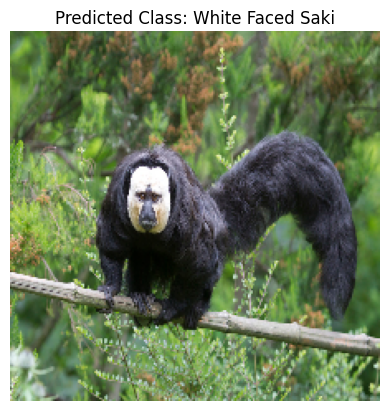

In [17]:
image_path1 = '/kaggle/input/new-images-for-testing/1.png'
predict_and_display(saved_model_path, image_path1, class_labels)

1/1 [==============================] - 0s 89ms/step


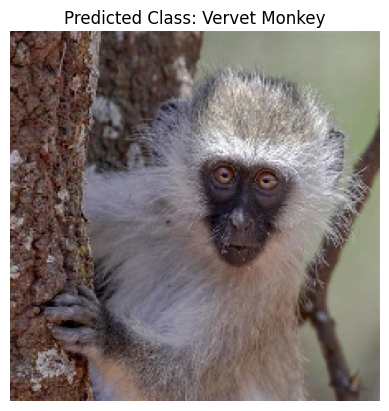

In [18]:
image_path2 = '/kaggle/input/new-images-for-testing/2.jpg'
predict_and_display(saved_model_path, image_path2, class_labels)

1/1 [==============================] - 0s 85ms/step


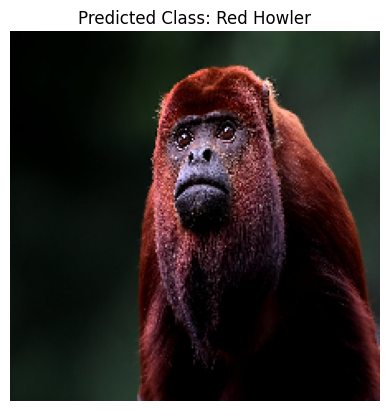

In [19]:
image_path3 = '/kaggle/input/new-images-for-testing/3.jpg'
predict_and_display(saved_model_path, image_path3, class_labels)

1/1 [==============================] - 0s 86ms/step


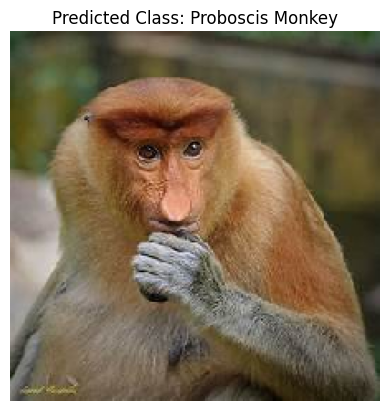

In [20]:
image_path4 = '/kaggle/input/new-images-for-testing/4.jpg'
predict_and_display(saved_model_path, image_path4, class_labels)

1/1 [==============================] - 0s 83ms/step


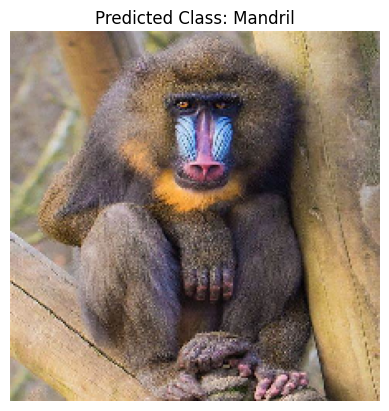

In [21]:
image_path5 = '/kaggle/input/new-images-for-testing/5.jpg'
predict_and_display(saved_model_path, image_path5, class_labels)

1/1 [==============================] - 0s 84ms/step


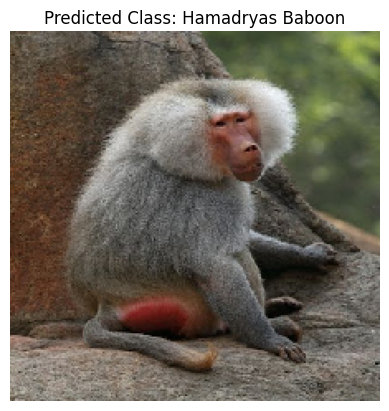

In [22]:
image_path6 = '/kaggle/input/new-images-for-testing/6.jpg'
predict_and_display(saved_model_path, image_path6, class_labels)

1/1 [==============================] - 0s 88ms/step


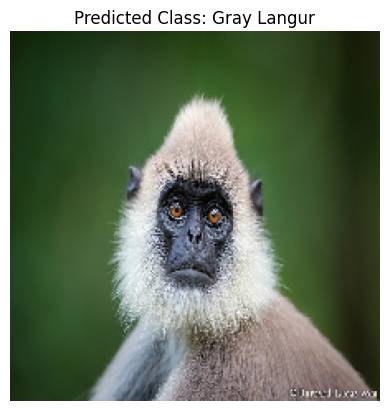

In [23]:
image_path7 = '/kaggle/input/new-images-for-testing/7.jpg'
predict_and_display(saved_model_path, image_path7, class_labels)

1/1 [==============================] - 0s 82ms/step


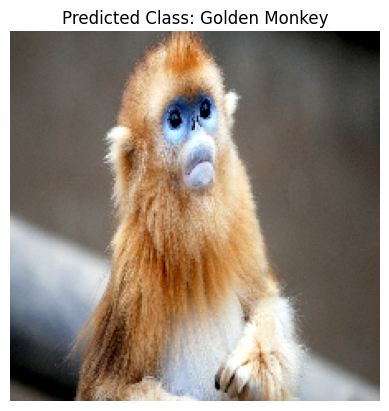

In [24]:
image_path8 = '/kaggle/input/new-images-for-testing/8.png'
predict_and_display(saved_model_path, image_path8, class_labels)

1/1 [==============================] - 0s 84ms/step


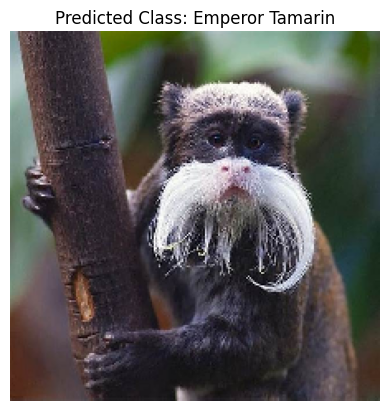

In [25]:
image_path9 = '/kaggle/input/new-images-for-testing/9.jpg'
predict_and_display(saved_model_path, image_path9, class_labels)

1/1 [==============================] - 0s 84ms/step


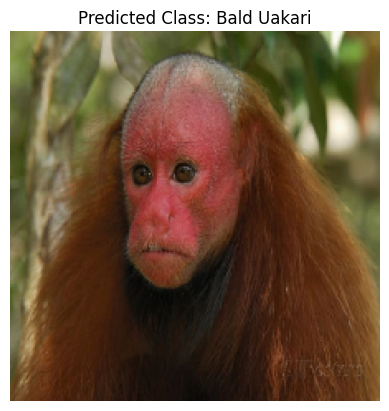

In [26]:
image_path10 = '/kaggle/input/new-images-for-testing/10.jpg'
predict_and_display(saved_model_path, image_path10, class_labels)

# 🎉 Conclusion
In conclusion, we successfully trained a model to classify 10 different monkey species with good accuracy. The model can be used to predict the species of monkeys in new images.

# Made by: Abdelrahman Eldaba 👨‍💻

Connect with me on [LinkedIn](https://www.linkedin.com/in/abdelrahman-eldaba-739805192/) 🌐

Look at my [GitHub](https://github.com/Abdelrahman47-code) 🚀